# Gradient Boosting

In [1]:
# Setup Libraries if needed
import pandas as pd
import sklearn
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.pyplot.style.use('ggplot')

In [2]:
# import the training data
training = pd.read_csv('training.csv', index_col='idx')

# view the data
training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
idx,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588,7,0,1,0,0


In [3]:
# Import SciKit Learn functions
from sklearn.metrics import roc_curve, auc , roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.cross_validation import train_test_split
from sklearn import grid_search

In [4]:
# Split the target from the input variables
X = training.iloc[:, 1:]
y = training.iloc[:, 0]

# Now, split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

In [7]:
# Cross Validated Grid Search approach
from datetime import datetime
startTime = datetime.now()

parameters = { 
    'learning_rate': [0.01,],
    'n_estimators': [1500,2000,2200,2500,2700,3000,3200,3500,3700,4000],
    'max_depth': [1,2,3,4,5]
    }


gbm = grid_search.GridSearchCV(GradientBoostingClassifier(loss='deviance', max_features = 'auto'), parameters, n_jobs=-1,
                                   scoring='roc_auc',refit=True)

gbm.fit(X, y)

tree_model = gbm.best_estimator_
print (gbm.best_score_, gbm.best_params_) 


print datetime.now() - startTime

(0.86455896652500497, {'n_estimators': 2500, 'learning_rate': 0.01, 'max_depth': 3})
6:20:36.765015


In [8]:
# Predict the test set
# import the test data
test = pd.read_csv('test.csv', index_col='idx')

X_ = test.iloc[:, 1:]

In [9]:
from datetime import datetime
startTime = datetime.now()
# Final training on entire set
GBMtree = GradientBoostingClassifier(loss='deviance', max_features = 'auto',learning_rate=0.01,
                                    n_estimators=2500,max_depth=3)

GBMtree.fit(X,y)

# Fit the decision tree classifier
GBMtree.predict(X_)

tree_preds = GBMtree.predict_proba(X_)[:, 1]

df = pd.DataFrame(tree_preds)

print datetime.now() - startTime

df.to_csv('preds_10.csv')

0:07:47.142286


## Outcome of Private Score Submission: AUC = 0.866133 #170
## Outcome of round 2 data cleaning AUC = 0.866709 #135
## Final outcoe from longer grid search AUC = 866799 #128

In [10]:
feature_cols = test.columns[1:]

pd.DataFrame({'feature':feature_cols, 'importance':GBMtree.feature_importances_}) 

,feature,importance
0,RevolvingUtilizationOfUnsecuredLines,0.245320
1,age,0.115301
2,NumberOfTime30-59DaysPastDueNotWorse,0.087780
3,DebtRatio,0.115106
4,MonthlyIncome,0.101423
5,NumberOfOpenCreditLinesAndLoans,0.072432
6,NumberOfTimes90DaysLate,0.125759
7,NumberRealEstateLoansOrLines,0.049564
8,NumberOfTime60-89DaysPastDueNotWorse,0.062806
9,NumberOfDependents,0.024508


In [11]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.shape[0]

y_score = GBMtree.fit(X_train, y_train).decision_function(X_test)

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

In [13]:
tree_preds = GBMtree.predict_proba(X_test)[:, 1]

roc_auc_score(y_test,tree_preds)

0.86676912775679726

In [14]:
actual = np.array(y_test)
predictions = np.array(tree_preds)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

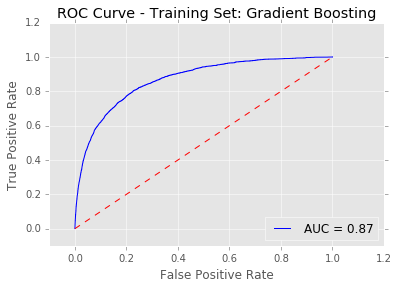

In [15]:
font = {'size'   : 10}
plt.rc('font', **font)
plt.title('ROC Curve - Training Set: Gradient Boosting')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

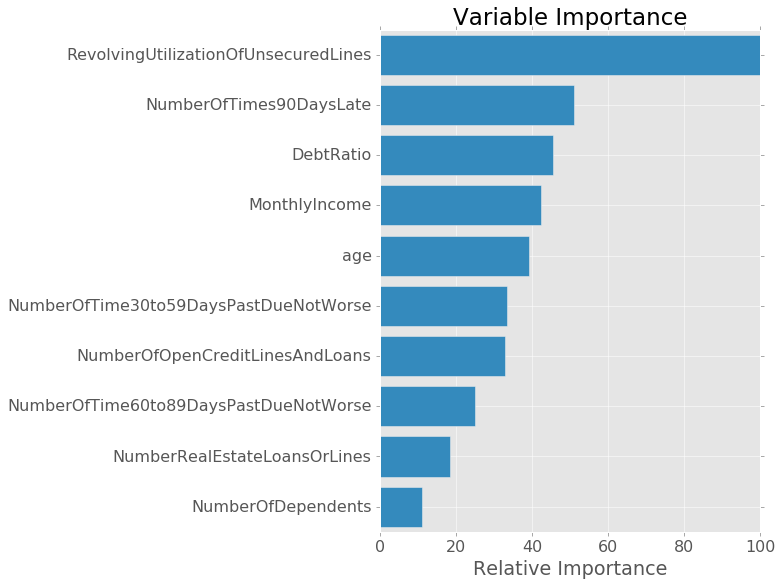

In [16]:
plt.figure(figsize=(6 *2.5,9))

feature_importance = GBMtree.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
font = {
        'size'   : 16}

plt.rc('font', **font)
plt.show()